(1, 3)

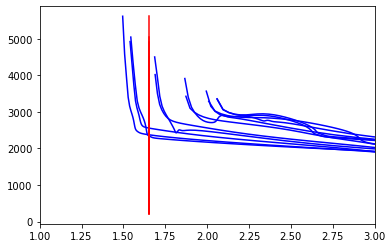

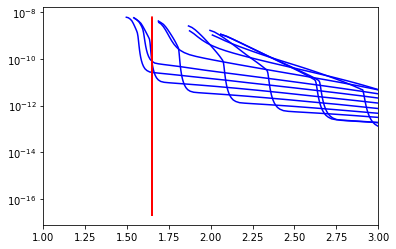

In [23]:
# Read darwin-dat-files
#
# extract 
# Radius, Density, and T_gas - columns
# all are in cgs
#
import matplotlib.pyplot as plt

c5d_star_r_au = 1.651
AUcm = 1.49598e13


modelname = 'M2n315u6'
steplist = [
    '230561',
    '230671',
    '230721',
    '230791',
    '230871',
    '231001',
    '231121',
    '231191',
    '231251',
    '231321',
    '231521'
]



for stepnumber in steplist:

    path = f'../darwin_data/{modelname}_sel/model.{stepnumber}.dat'

    radius_cm = []
    radius_au = []
    gas_density = []
    gas_temperature = []


    with open(path, 'r') as f:
        for nn,line in enumerate(f.readlines()):
            if nn > 18:

                line_list = line.strip().split('  ')

                radius_cm.append(float(line_list[0]))
                radius_au.append(float(line_list[0])/AUcm)
                gas_density.append(float(line_list[1]))
                gas_temperature.append(float(line_list[2]))


    plt.figure(1)
    plt.plot(radius_au,gas_temperature,'b')
    plt.plot(
        [c5d_star_r_au,c5d_star_r_au],
        [min(gas_temperature),max(gas_temperature)],'r'
    )


    plt.figure(2)
    plt.plot(radius_au,gas_density,'b')
    plt.plot(
        [c5d_star_r_au,c5d_star_r_au],
        [min(gas_density),max(gas_density)],'r'
    )
    plt.yscale('log')

plt.figure(1)
plt.xlim(1,3)
plt.figure(2)
plt.xlim(1,3)



Så, hur göra?

1. definiera stjärnan

 * först leta upp vilka data som faktiskt går innanför c5d-stjärnan?
  - eller ska jag försöka normalisera om stjärnan till en sån?
  - samma sak med temperaturen dåju

 * eller ta en medelstjärna av alla data? och sen normalisera om den till en som uppfyller samma storlek o temperatur som co5boldstjärnan?

2. stuva in det i r3d-gridet
 * dvs, sfäriska koordinater, översätta densiteter, temperaturer till data för varje gridcell
 * allt som är inom stjärnan kan ju sättas till konstant densitet o temperatur
 * och så ska radien inte gå utanför co5bold-kuben. Dvs jag inför nog gas-fördelning hela vägen? eller ska jag bara ha gasfördelning upp till en viss radie ovanför stjärnans yta o sen gå över till co5boldgas?
  - med tanke på att med pnktkällorna har jag ingen gas alls, bara stoft så tror jag på det förnämnda mer

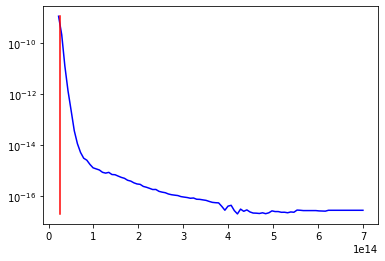

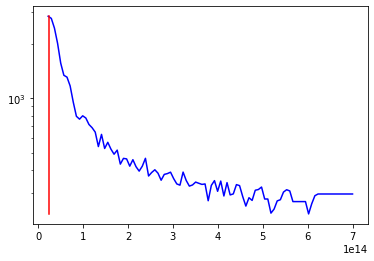

In [86]:
# Test to make an average darwin-star
#
# extract 
# Radius, Density, and T_gas - columns
# all are in cgs
#
import matplotlib.pyplot as plt
import numpy as np

import analyze_r3d_functions as a3d

AUcm = 1.49598e13
c5d_star_r_cm = 1.651 * AUcm

modelname = 'M2n315u6'
steplist = [
    '230561',
    '230671',
    '230721',
    '230791',
    '230871',
    '231001',
    '231121',
    '231191',
    '231251',
    '231321',
    '231521'
]

# Load all Darwin data
Ntimesteps = len(steplist)
Ncells = []
all_radii = []
all_density = []
all_temperature = []

for stepnumber in steplist:

    path = f'../darwin_data/{modelname}_sel/model.{stepnumber}.dat'

    path = f'../darwin_data/{modelname}_sel/model.{stepnumber}.dat'

    radius_cm = []
    radius_au = []
    gas_density = []
    gas_temperature = []


    with open(path, 'r') as f:
        for nn,line in enumerate(f.readlines()):
            if nn > 18:

                line_list = line.strip().split('  ')

                radius_cm.append(float(line_list[0]))
                gas_density.append(float(line_list[1]))
                gas_temperature.append(float(line_list[2]))

    # Save and reverse the radial direction
    Ncells.append(len(radius_cm))
    all_radii.append(radius_cm[::-1])
    all_density.append(gas_density[::-1])
    all_temperature.append(gas_temperature[::-1])





# Define grid to average into
Naverage = max(Ncells)
average_radius = np.linspace(
    min(min(all_radii)),
    max(max(all_radii)),
    Naverage
)
average_gas_density = np.zeros(Naverage)
average_gas_T = np.zeros(Naverage)
average_cell_counter = np.zeros(Naverage)


# Loop over each models radius and densities
for nstep in range(Ntimesteps):

    # Loop over all data in each time step
    for nn in range(Ncells[nstep]):


        



        # Check where these data are closest to average_radius
        for na in range(Naverage - 1):
            if all_radii[nstep][nn] >= average_radius[na] and all_radii[nstep][nn] < average_radius[na+1]:

                # TODO
                # THIS DOESNT WORK!

                # test with np.where instead?

                average_gas_density[na] += all_density[nstep][nn]
                average_gas_T[na] += all_temperature[nstep][nn]

                average_cell_counter[na] += 1


# TODO save as separate function!
hole_lists = []
hole_list = []
nprev = -2
zero_elements = np.where(average_cell_counter == 0)[0]
for nn,nzero in enumerate(zero_elements):

    if nn == 0:
        hole_list.append(nzero)

    if nn > 0 and nn < len(zero_elements)-1:

        if nzero+1 == zero_elements[nn+1]:
            hole_list.append(nzero)

        elif nzero+1 != zero_elements[nn+1] and nzero-1 == zero_elements[nn-1]:
            hole_list.append(nzero)
            hole_lists.append(hole_list)
            hole_list = []

        # Save list and reset
        else:
            hole_lists.append(hole_list)
            hole_list = []

    if nn == len(zero_elements)-1:
        hole_list.append(nzero)
        hole_lists.append(hole_list)
        hole_list = []



# Remove zeros in cell counter
for na in range(Naverage):
    if average_cell_counter[na] == 0:
        average_cell_counter[na] = 1


# Average the data
average_gas_density /= average_cell_counter
average_gas_T /= average_cell_counter



# Average data around holes in average data
for zero_list in hole_lists:

    # Make sure were not in the end of the array
    if zero_list[-1] != Naverage-1:

        # Take average of prev and next index
        average_gas_density[zero_list] = 0.5*(average_gas_density[zero_list[0]-1] + average_gas_density[zero_list[-1]+1])
        average_gas_T[zero_list] = 0.5*(average_gas_T[zero_list[0]-1] + average_gas_T[zero_list[-1]+1])
    
    # For the end of the array, just take the final real value
    if zero_list[-1] == Naverage-1:
        average_gas_density[zero_list] = average_gas_density[zero_list[0]-1] 
        average_gas_T[zero_list] = average_gas_T[zero_list[0]-1]



plt.figure(1)
plt.plot(
    average_radius,
    average_gas_density,
    'b'
)
plt.plot(
    [c5d_star_r_cm,c5d_star_r_cm],
    [average_gas_density.min(),average_gas_density.max()],'r'
)
plt.yscale('log')


plt.figure(2)
plt.plot(
    average_radius,
    average_gas_T,
    'b'
)
plt.plot(
    [c5d_star_r_cm,c5d_star_r_cm],
    [average_gas_T.min(),average_gas_T.max()],'r'
)
plt.yscale('log')


In [87]:
import analyze_r3d_functions as a3d


# Load radial grid of r3d cells (small model!)

r3d_griddistances = a3d.load_griddistances(
    gridpath='../r3dresults/st28gm06n056/grid_distances.csv',
    amrpath='../r3dresults/st28gm06n056/amr_grid.inp',
)
r3d_radius = r3d_griddistances[:,0]

r3d_cellsizes = a3d.load_cellsizes(
    sizepath='../r3dresults/st28gm06n056/grid_cellsizes.csv',
    amrpath='../r3dresults/st28gm06n056/amr_grid.inp'
)


In [93]:
import analyze_r3d_functions as a3d


# Load radial grid of r3d cells (big model!)

r3d_griddistances = a3d.load_griddistances(
    gridpath='../r3dresults/st28gm06n052/grid_distances.csv',
    amrpath='../r3dresults/st28gm06n052/amr_grid.inp',
)
r3d_radius = r3d_griddistances[:,0]

r3d_cellsizes = a3d.load_cellsizes(
    sizepath='../r3dresults/st28gm06n052/grid_cellsizes.csv',
    amrpath='../r3dresults/st28gm06n052/amr_grid.inp'
)

In [94]:
import numpy as np

print(np.shape(r3d_griddistances[:,3]))
print(np.shape(r3d_cellsizes))

(19590712,)
(19590712,)


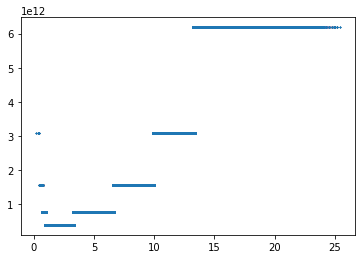

In [95]:
import matplotlib.pyplot as plt
AUcm = 1.49598e13 # AU in cm

plt.plot(r3d_radius/AUcm,r3d_cellsizes,'.',markersize=1)


In [96]:

# do i need to change the order of r3d_radius for this interpolation to work??

# default setting of interp is to keep first o last value outside the range
r3d_darwindensity = np.interp(r3d_radius,average_radius,average_gas_density)
r3d_darwintemperature = np.interp(r3d_radius,average_radius,average_gas_T)






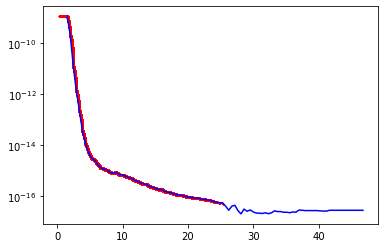

In [99]:
plt.figure(1)
plt.plot(
    r3d_radius/AUcm,
    r3d_darwindensity,
    'r.',markersize=1
)
plt.plot(
    average_radius/AUcm,
    average_gas_density,
    'b'
)
plt.yscale('log')



plt.figure(2)
plt.plot(
    r3d_radius/AUcm,
    r3d_darwintemperature,
    'r.',markersize=1
)
plt.plot(
    average_radius/AUcm,
    average_gas_T,
    'b'
)



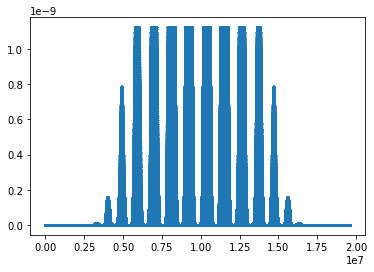

In [100]:
plt.plot(r3d_darwindensity,'.',markersize=1)